In [1]:
import os, sys

import numpy as np
import pandas as pd

import anndata
import scanpy as sc
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt

In [2]:
path = '/Users/busracagirici/Documents/scrnaseq/citeseq/'
save_tables = '/Users/busracagirici/Documents/scrnaseq/citeseq/tables/'
save_figures = '/Users/busracagirici/Documents/scrnaseq/citeseq/figures/'


In [3]:
#adata = sc.read_h5ad(path + 'data/merged_dengue_and_covid_all.h5ad')
adata = sc.read_h5ad(path + 'data/merged_citeseq_092024_7.h5ad')

#adata

In [4]:
filtered = adata[(adata.obs.Dataset.isin(['Children_viscRNAseq', 'Adults_citeseq'])) & 
                 (adata.obs.cell_quality == 'high')]
filtered = filtered[filtered.obs.ID.isin(['1_019_01', '6_023_01', '5_030_01', '5_193_01', '5_154_01', '6_001_01', '5_041_01', '1_140_01', '1_144_01', '5_044_01', '1_002_01', '1_113_01', '5_010_01', '5_130_01', '1_183_01', '1_003_1', '1_026_02', '1-172-01', '1_013_01', '1_053_01', '1_001_1', '5_049_01', '1-056-01', '1_036_02'])]
#filtered

In [5]:
filtered.obs.cell_type_new.cat.categories

Index(['B cells', 'Doublets', 'Erythroblasts', 'HSPCs', 'Monocytes',
       'NK cells', 'Plasmablasts', 'T cells', 'cDCs', 'pDCs', 'unknown',
       'unknown2', 'Platelets'],
      dtype='object')

In [6]:
filtered = filtered[filtered.obs.cell_type_new.isin(['B cells', 'Monocytes', 'NK cells', 'Plasmablasts', 
                                                        'T cells', 'cDCs', 'pDCs', 'Platelets', 'HSPCs'])]

filtered.obs.cell_type_new.cat.reorder_categories(['Monocytes', 'NK cells', 'T cells', 'B cells', 'Plasmablasts', 
                                                        'cDCs', 'pDCs', 'Platelets', 'HSPCs'], inplace=True)

sc.pp.normalize_total(filtered, target_sum=1e6)
sc.pp.log1p(filtered, base=2)
filtered.raw = filtered
sc.pp.filter_genes(filtered, min_cells=3)


2024-09-25 22:14:40,859 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-09-25 22:15:03,637 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-09-25 22:15:03,953 - harmonypy - INFO - Iteration 1 of 10
2024-09-25 22:15:30,990 - harmonypy - INFO - Iteration 2 of 10
2024-09-25 22:15:58,223 - harmonypy - INFO - Iteration 3 of 10
2024-09-25 22:16:25,423 - harmonypy - INFO - Converged after 3 iterations


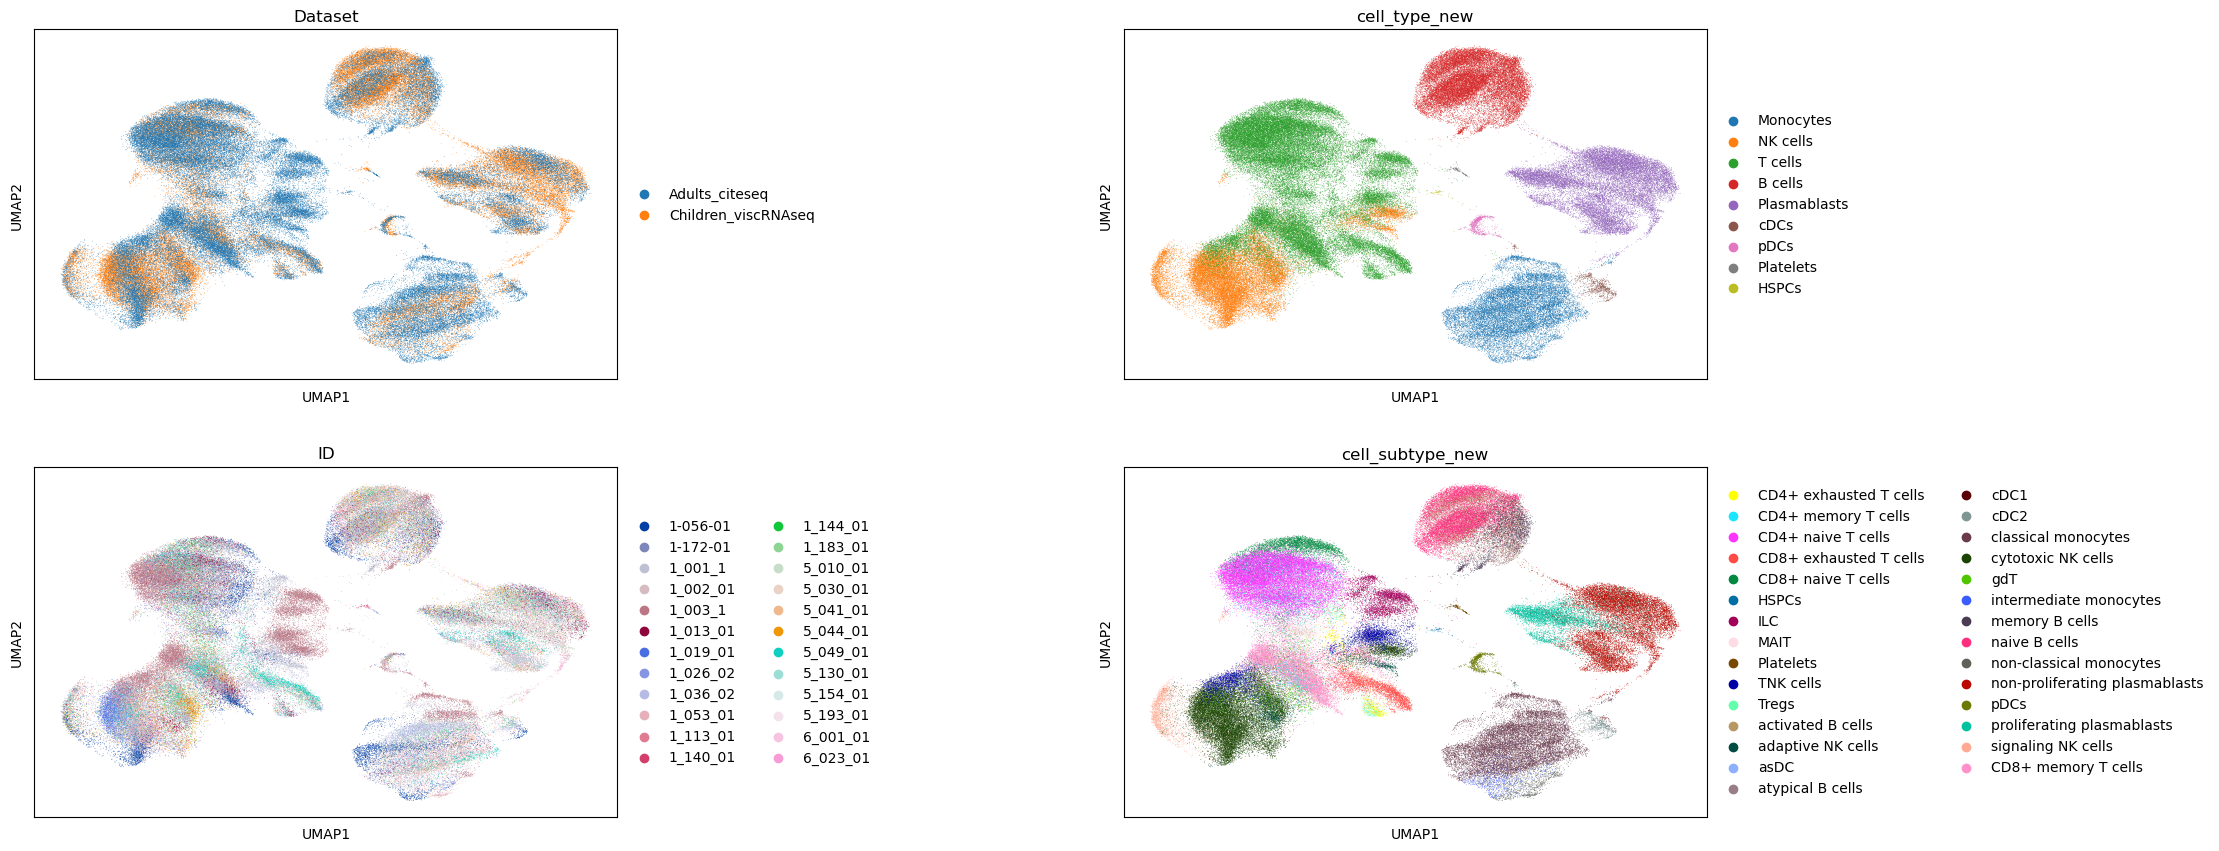

In [7]:
geneids=['IGKV', 'IGHV', 'IGLV', 'IGLC', 'IGLL', 'IGKC', 'IGHC', 'TRAV', 'TRBV']
gene = [x for x in filtered.var_names if x[:4] not in geneids].copy()
filtered = filtered[:,gene]
    
sc.pp.highly_variable_genes(filtered, n_top_genes =2000, flavor = 'cell_ranger', batch_key='ID')
sc.pp.pca(filtered, n_comps=50, use_highly_variable=True, svd_solver='arpack')

sc.external.pp.harmony_integrate(filtered, 'Dataset', basis='X_pca', adjusted_basis='X_pca_harmony')
sc.pp.neighbors(filtered, n_neighbors=10, n_pcs=40, use_rep = 'X_pca_harmony')
sc.tl.umap(filtered)
res=0.5
sc.tl.leiden(filtered, resolution=res, key_added = f'leiden_r{res}')
sc.pl.umap(filtered, color=['Dataset', 'cell_type_new',
                            'ID', 'cell_subtype_new'], 
           wspace=0.7, ncols=2, )

In [8]:
sns.color_palette(palette='Set3')

[(0.5529411764705883, 0.8274509803921568, 0.7803921568627451),
 (1.0, 1.0, 0.7019607843137254),
 (0.7450980392156863, 0.7294117647058823, 0.8549019607843137),
 (0.984313725490196, 0.5019607843137255, 0.4470588235294118),
 (0.5019607843137255, 0.6941176470588235, 0.8274509803921568),
 (0.9921568627450981, 0.7058823529411765, 0.3843137254901961),
 (0.7019607843137254, 0.8705882352941177, 0.4117647058823529),
 (0.9882352941176471, 0.803921568627451, 0.8980392156862745),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627),
 (0.7372549019607844, 0.5019607843137255, 0.7411764705882353),
 (0.8, 0.9215686274509803, 0.7725490196078432),
 (1.0, 0.9294117647058824, 0.43529411764705883)]

In [9]:
filtered.obs['cell_type_new'].cat.categories

Index(['Monocytes', 'NK cells', 'T cells', 'B cells', 'Plasmablasts', 'cDCs',
       'pDCs', 'Platelets', 'HSPCs'],
      dtype='object')

In [10]:
c = list(sns.color_palette(palette='Set3'))
filtered.uns['cell_type_new_colors'] = [c[0], c[2], c[3], c[4], c[5], c[7], c[9], c[6], c[10]]
filtered.uns['Dataset_colors'] = ['#ff7f0e', '#2ca02c']

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

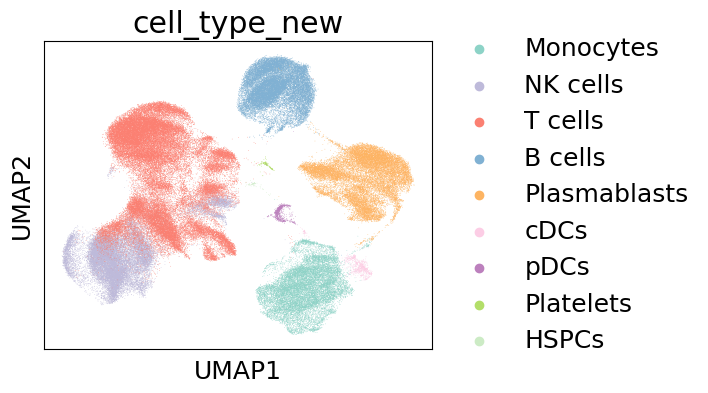

In [11]:
from matplotlib import rcParams
rcParams['font.size']=18

fig, ax1 = plt.subplots(1,1, figsize=[5,4])
sc.pl.umap(filtered,
           color=['cell_type_new',], ax=ax1)
fig.tight_layout(pad=1)
#plt.savefig(figure_path+'vRNA_and_ct_umaps_min_vRNA_4_CPM.svg', format="svg")
plt.show()

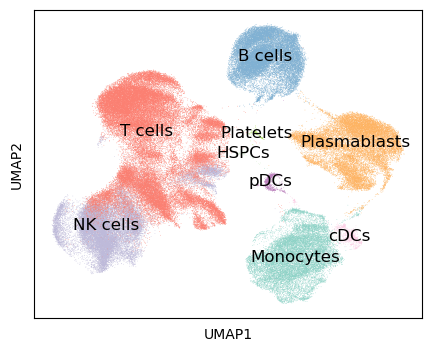

In [12]:
from matplotlib import rcParams
rcParams['font.size']=10

fig, ax1 = plt.subplots(1,1, figsize=[5,4])
sc.pl.umap(filtered, legend_loc='on data', legend_fontsize=12, legend_fontweight='normal',
           frameon='False', title='',
           color=['cell_type_new',], ax=ax1)
fig.tight_layout(pad=1)
#plt.savefig(figure_path+'vRNA_and_ct_umaps_min_vRNA_4_CPM.svg', format="svg")
plt.show()

In [13]:
filtered.obs.cell_subtype_new.cat.categories

Index(['CD4+ exhausted T cells', 'CD4+ memory T cells', 'CD4+ naive T cells',
       'CD8+ exhausted T cells', 'CD8+ naive T cells', 'HSPCs', 'ILC', 'MAIT',
       'Platelets', 'TNK cells', 'Tregs', 'activated B cells',
       'adaptive NK cells', 'asDC', 'atypical B cells', 'cDC1', 'cDC2',
       'classical monocytes', 'cytotoxic NK cells', 'gdT',
       'intermediate monocytes', 'memory B cells', 'naive B cells',
       'non-classical monocytes', 'non-proliferating plasmablasts', 'pDCs',
       'proliferating plasmablasts', 'signaling NK cells',
       'CD8+ memory T cells'],
      dtype='object')

In [14]:
filtered.obs.cell_subtype_new.cat.reorder_categories(['classical monocytes', 'non-classical monocytes', 'intermediate monocytes',
                                                      'signaling NK cells', 'cytotoxic NK cells', 'adaptive NK cells',
                                                      'CD4+ naive T cells', 'CD4+ memory T cells', 'CD4+ exhausted T cells', 
       'CD8+ naive T cells', 'CD8+ memory T cells', 'CD8+ exhausted T cells', 
       'Tregs', 'MAIT', 'gdT', 'ILC', 'TNK cells', 
                                                      'naive B cells', 'memory B cells', 'atypical B cells', 'activated B cells', 
                                                      'proliferating plasmablasts', 'non-proliferating plasmablasts', 
                                                      'cDC1', 'cDC2', 'asDC', 'pDCs', 'Platelets',
                                                      'HSPCs', ], inplace=True)

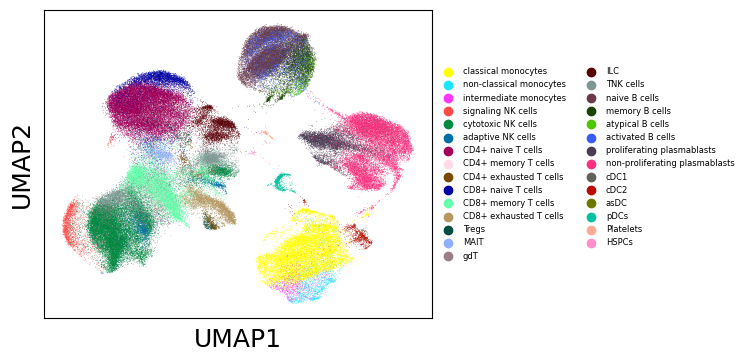

In [15]:
rcParams['font.size']=18

fig, ax1 = plt.subplots(1,1, figsize=[5,4])
sc.pl.umap(filtered, title='', legend_fontsize=6, legend_fontweight='normal',
           color=['cell_subtype_new',], ax=ax1)
fig.tight_layout(pad=1)
#plt.savefig(figure_path+'vRNA_and_ct_umaps_min_vRNA_4_CPM.svg', format="svg")
plt.show()

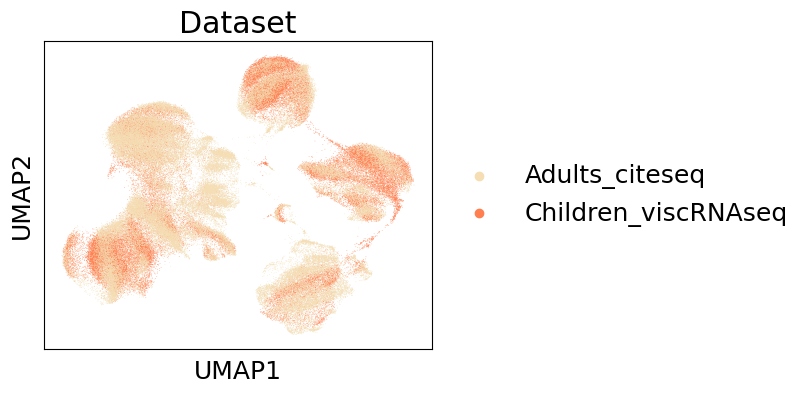

In [16]:
filtered.uns['Dataset_colors'] = ['wheat', 'coral']
fig, ax1 = plt.subplots(1,1, figsize=[5,4])
sc.pl.umap(filtered,
           color=['Dataset',], ax=ax1)
fig.tight_layout(pad=1)
#plt.savefig(figure_path+'vRNA_and_ct_umaps_min_vRNA_4_CPM.svg', format="svg")
plt.show()

In [17]:
filtered.obs['Dengue_exposure'].cat.categories

Index(['Primary', 'Secondary', 'ndet'], dtype='object')

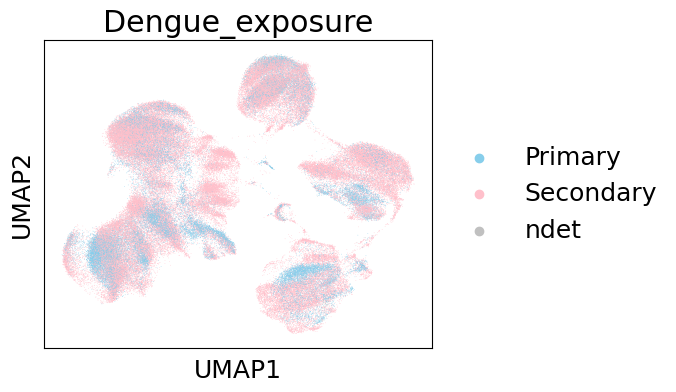

In [19]:
filtered.uns['Dengue_exposure_colors'] = ['skyblue', 'pink', 'silver']

fig, ax1 = plt.subplots(1,1, figsize=[5,4])
sc.pl.umap(filtered,
           color=['Dengue_exposure',], ax=ax1)
fig.tight_layout(pad=1)
#plt.savefig(figure_path+'vRNA_and_ct_umaps_min_vRNA_4_CPM.svg', format="svg")
plt.show()

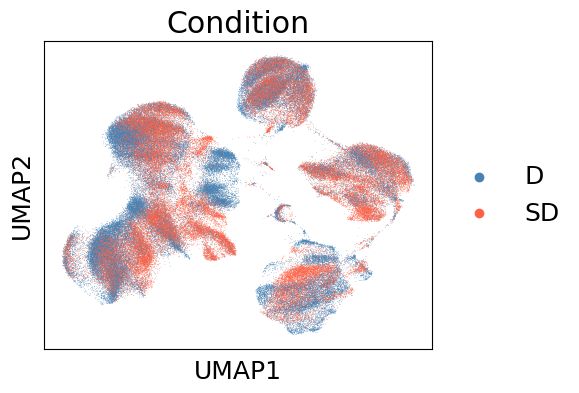

In [20]:
filtered.uns['Condition_colors'] = ['steelblue', 'tomato', ]

fig, ax1 = plt.subplots(1,1, figsize=[5,4])
sc.pl.umap(filtered, 
           color=['Condition',], ax=ax1)
fig.tight_layout(pad=1)
#plt.savefig(figure_path+'vRNA_and_ct_umaps_min_vRNA_4_CPM.svg', format="svg")


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

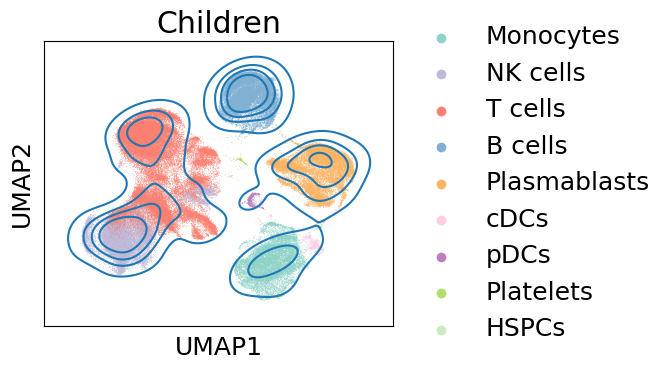

In [26]:
f1 = filtered[filtered.obs.Dataset=='Children_viscRNAseq'].copy()
fig, ax1 = plt.subplots(1,1, figsize=[7,4])
sc.pl.umap(filtered, title='Children',
           color=['cell_type_new',], ax=ax1, show=False)
sns.kdeplot(f1.obsm['X_umap'][:,0],f1.obsm['X_umap'][:,1], levels=5, ax=ax1)
fig.tight_layout(pad=1)
#plt.savefig(figure_path+'vRNA_and_ct_umaps_min_vRNA_4_CPM.svg', format="svg")
plt.show()



*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

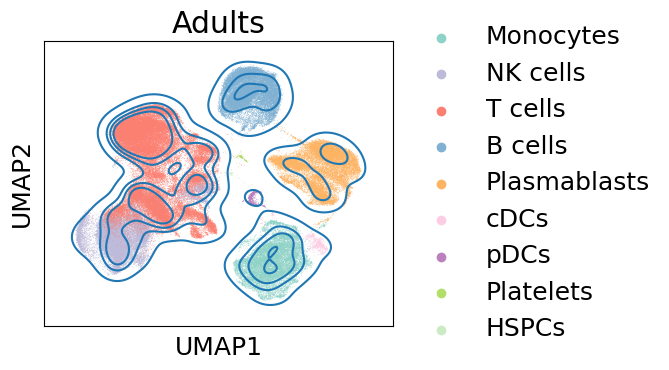

In [27]:
f2 = filtered[filtered.obs.Dataset=='Adults_citeseq'].copy()
fig, ax1 = plt.subplots(1,1, figsize=[7,4])
sc.pl.umap(filtered, title='Adults',
           color=['cell_type_new',], ax=ax1, show=False)
sns.kdeplot(f2.obsm['X_umap'][:,0],f2.obsm['X_umap'][:,1], levels=5, ax=ax1)
fig.tight_layout(pad=1)
#plt.savefig(figure_path+'vRNA_and_ct_umaps_min_vRNA_4_CPM.svg', format="svg")
plt.show()



In [23]:
### cell type annotation
marker_genes = ['CST3', 'LYZ', #myeloid
                  "FCGR3A", "CD14", # CD14 and CD16 Monocyte
                  "APOE", "C1QA", # Macrophage
                  #"ISG15", # antiviral
                  'NKG7', 'GNLY', 'KLRB1', "NCAM1", 'KLRC2', 'XCL1', #NK
                "CD3D",'IL7R', "CCR7","SELL","CD27","CD4","CD40LG","CD8A", # T cells
                "GZMH", 'GZMA', 'GZMK', 'GZMB', 'GNLY',
                  "IL2RA", "FOXP3","IKZF2", #Treg
                  "SLC4A10", #MAIT
                  "TRGV9","TRDV2", #gdT
                  "FCER2","CXCR5","CD19","CCR6","IGHD","MS4A1","CD79A","TNFRSF13B","ENTPD1","MKI67", # B/PB cells
                "CLEC9A","FCER1A",'CD1C','IRF8',"CLEC4C","IL3RA","AXL","SIGLEC6", # DCs
  
                  "PPBP","PF4",'ITGA2B', # Platelet
                  'ALAS2', 'HBA1', 'HBB', # Erythrocyte
                "KIT","CD34", # HSPC
                  #"FCGR3B","NAMPT",'CEACAM8','DEFA3', # Neutrophil
                  #"EPCAM","CDH1","CDH6", # Epi
                #"MS4A2","GATA2", # MAST
                #"OLIG1","MOG","CLDN11" # Endo
                 ]


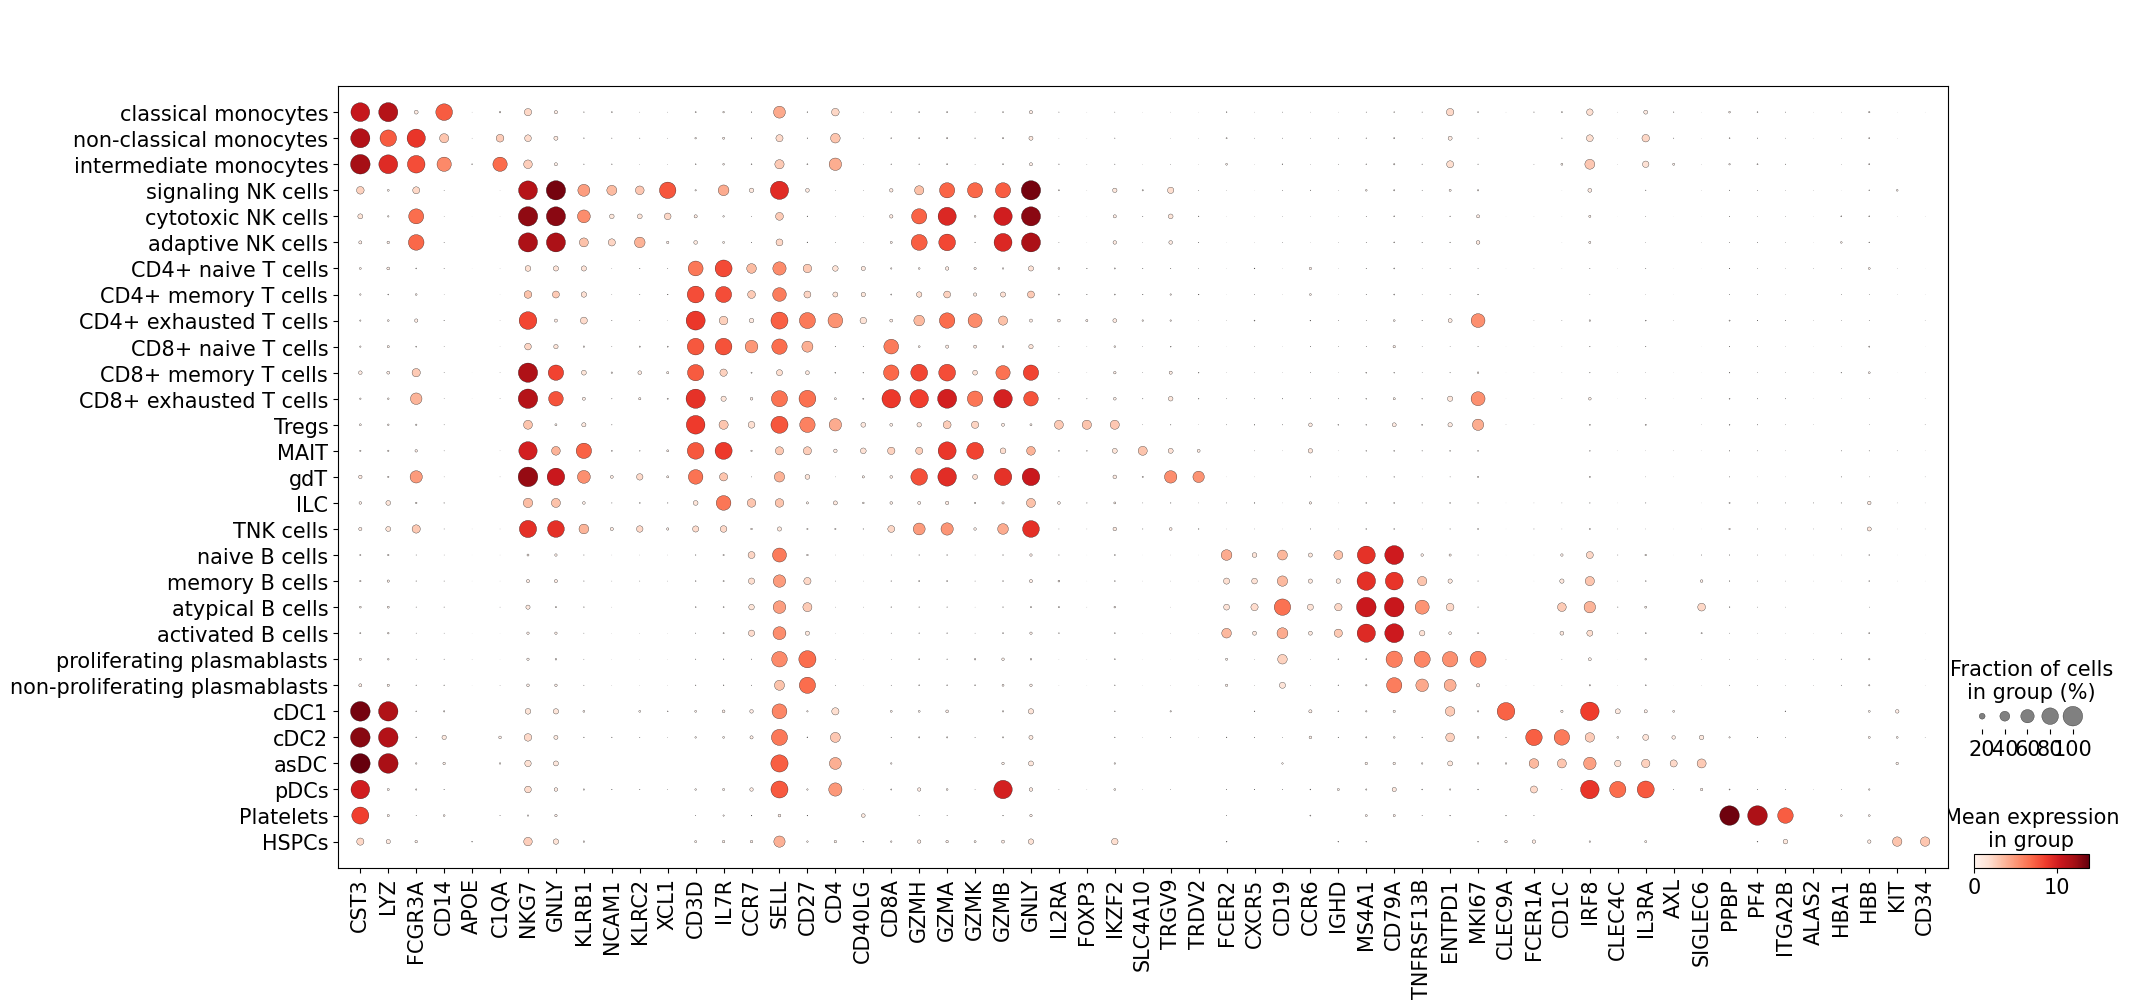

In [24]:
sc.pl.dotplot(filtered, marker_genes,
              groupby='cell_subtype_new', dendrogram=False)

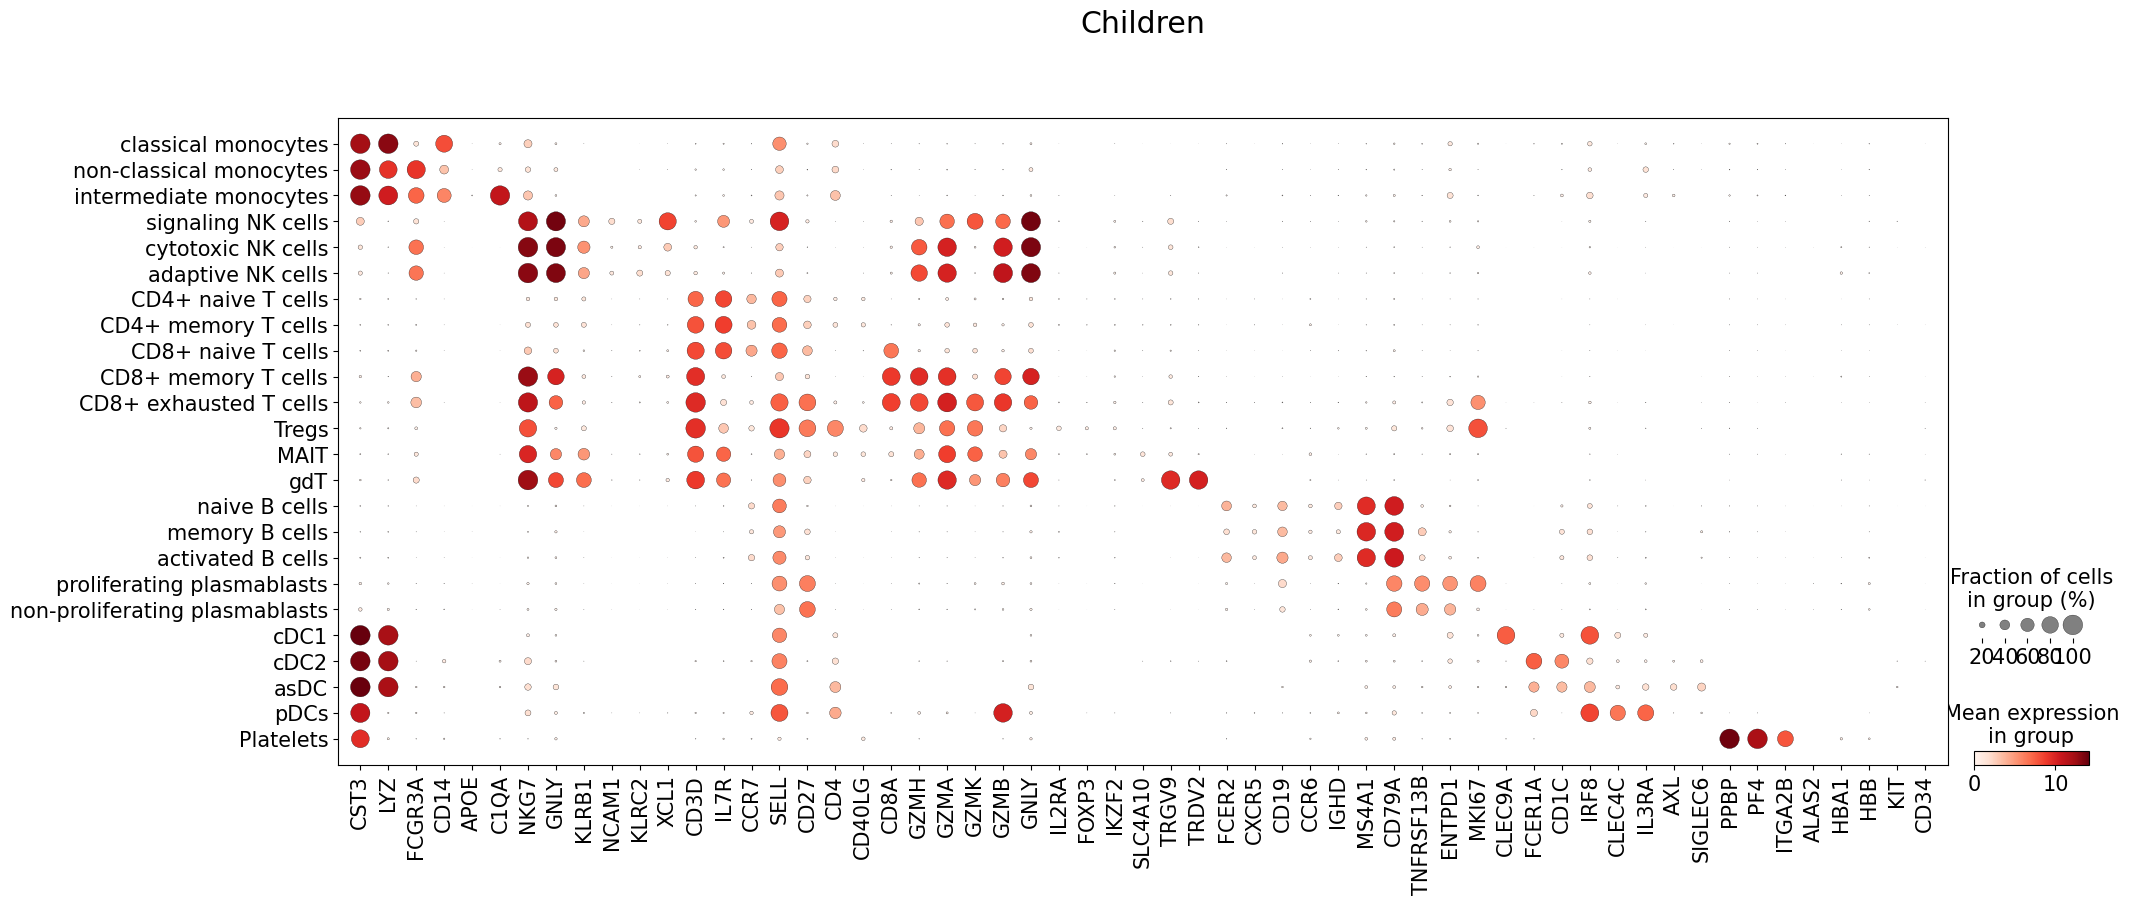

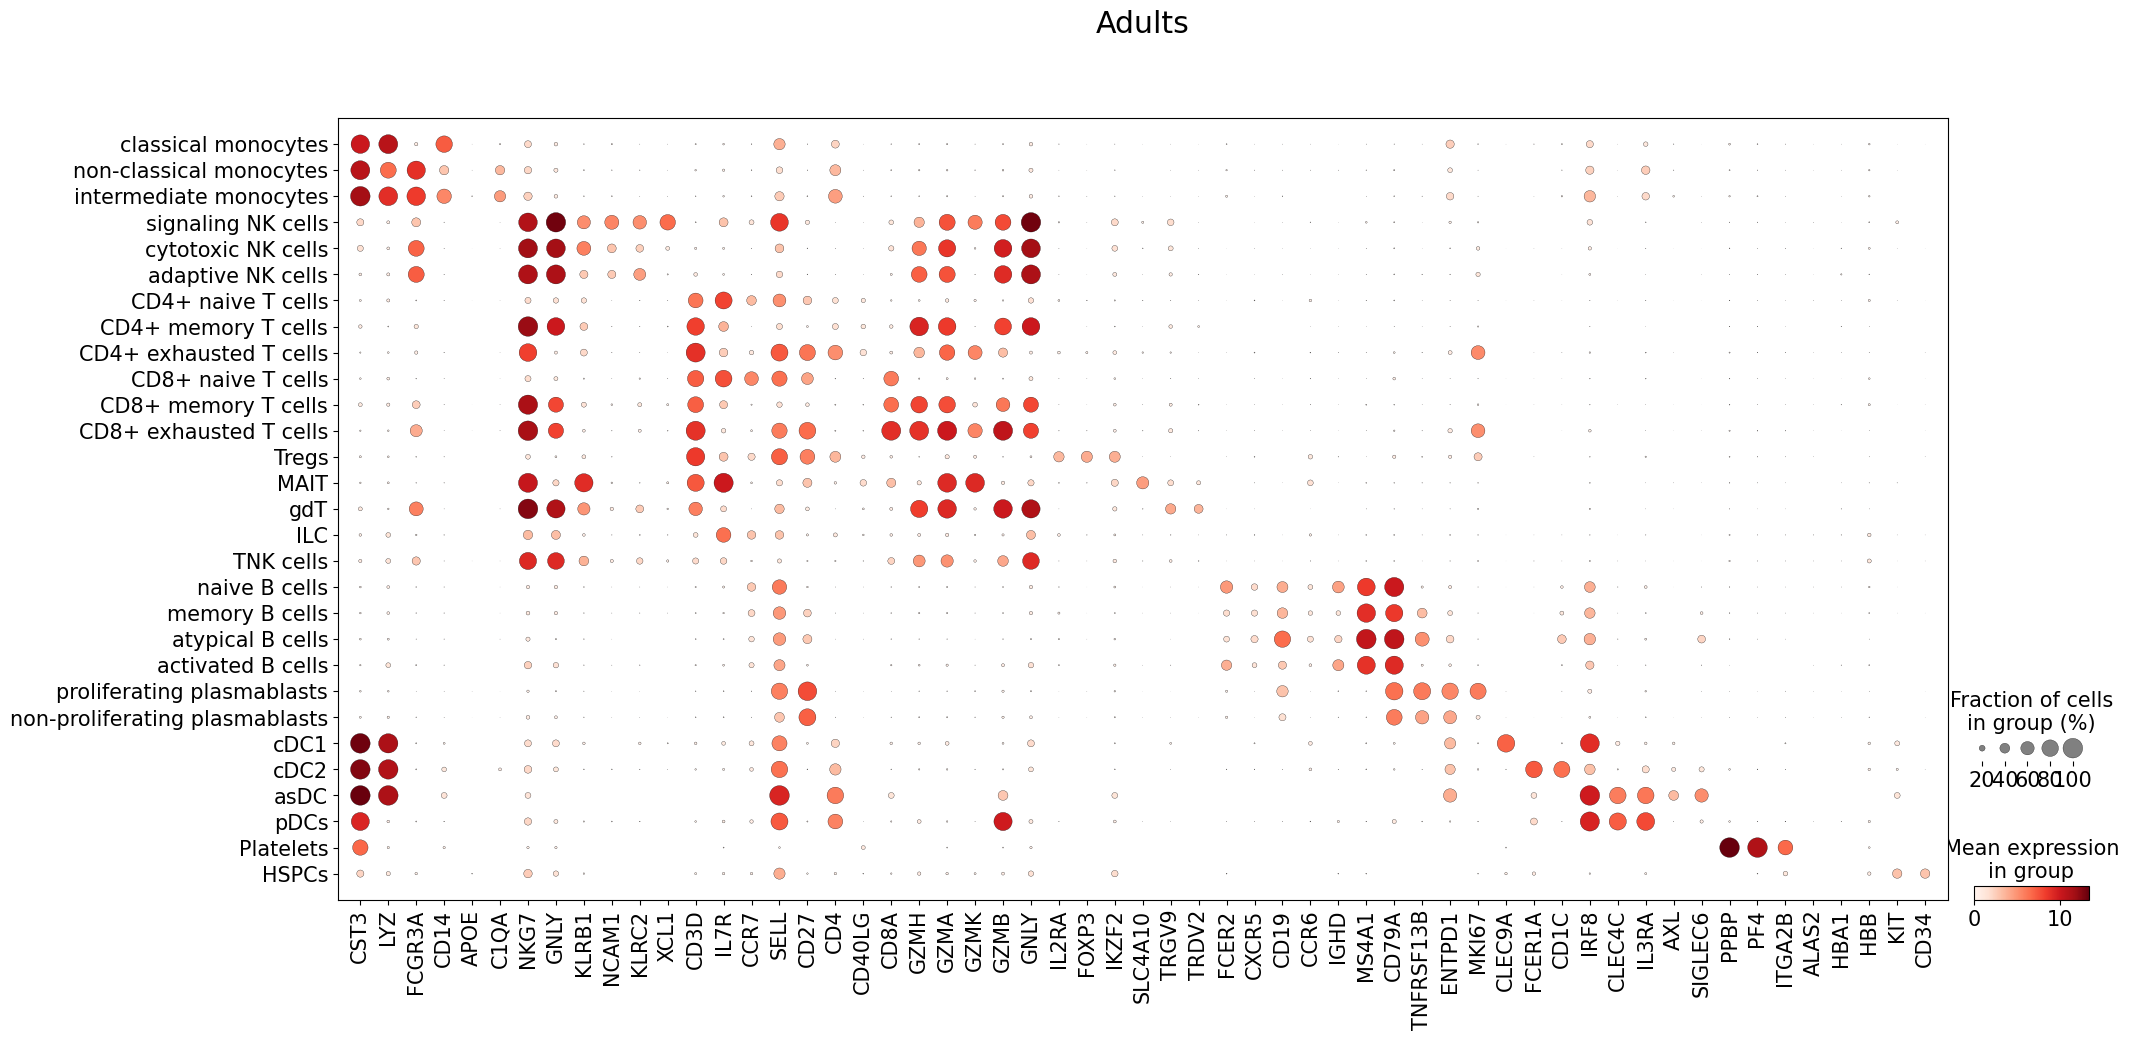

In [29]:
sc.pl.dotplot(f1, marker_genes, title='Children',
              groupby='cell_subtype_new', dendrogram=False)

sc.pl.dotplot(f2, marker_genes, title='Adults',
              groupby='cell_subtype_new', dendrogram=False)

In [30]:
df = filtered.obs.groupby(['Dataset', 'cell_type_new', 'cell_subtype_new', 'Stage',]).size()
df[df!=0].loc['Adults_citeseq'].loc['HSPCs']

cell_subtype_new  Stage
HSPCs             acute    61
dtype: int64

In [31]:
cts = ['Monocytes', 'NK cells', 'T cells', 'B cells', 'Plasmablasts']
filtered_ct = filtered[filtered.obs.cell_type_new.isin(cts)].copy()

## prepare cell abundance table for adult data
adata_adult = filtered_ct[filtered_ct.obs.Dataset.isin(['Adults_citeseq'])]

df = pd.DataFrame([])
for ct in adata_adult.obs.cell_type_new.cat.categories:
    adata_ct = adata_adult[adata_adult.obs.cell_type_new == ct].copy()
    tmp = pd.crosstab(adata_ct.obs['ID'], adata_ct.obs['cell_subtype_new'], normalize='index')
    #tmp.plot.bar(stacked=True).legend(bbox_to_anchor=(1.6, 1.0), loc='upper right')
    df = pd.concat([df, tmp], axis=1, join='outer')

IDs= adata_adult.obs.ID.cat.categories
df['Condition']=''
cond = {'D': 'a_D', 'SD': 'a_SDp',}
for ID in IDs:
    c = adata_adult[adata_adult.obs.ID.isin([ID])].obs['Condition'].unique()[0]
    df['Condition'][ID] = cond[c]
df_adult = pd.melt(df.reset_index(), id_vars =['ID', 'Condition'], value_vars =df.columns[:-1])


## prepare cell abundance table for pediatric data
adata_kid = filtered_ct[filtered_ct.obs.Dataset.isin(['Children_viscRNAseq'])]

df = pd.DataFrame([])
for ct in adata_kid.obs.cell_type_new.cat.categories:
    adata_ct = adata_kid[adata_kid.obs.cell_type_new == ct].copy()
    tmp = pd.crosstab(adata_ct.obs['ID'], adata_ct.obs['cell_subtype_new'], normalize='index')
    #tmp.plot.bar(stacked=True).legend(bbox_to_anchor=(1.6, 1.0), loc='upper right')
    df = pd.concat([df, tmp], axis=1, join='outer')

IDs= adata_kid.obs.ID.cat.categories
df['Condition']=''
cond = {'D': 'p_D', 'SD': 'p_SDp'}
for ID in IDs:
    c = adata_kid[adata_kid.obs.ID.isin([ID])].obs['Condition'].unique()[0]
    df['Condition'][ID] = cond[c]
df_kid = pd.melt(df.reset_index(), id_vars =['ID', 'Condition'], value_vars =df.columns[:-1])


## merge adult and pediatric tables
## and reorder cell subtypes
df = pd.concat([df_adult, df_kid], ignore_index=True)
cst = df['cell_subtype_new'].unique()
#cst = [cst[-1], *cst[:-1]]
df = df.set_index('cell_subtype_new').loc[cst].reset_index()
df.fillna(0, inplace=True)
df

cell_subtype_new        ID Condition     value
0               classical monocytes  1-056-01       a_D  0.830467
1               classical monocytes  1-172-01       a_D  0.834646
2               classical monocytes   1_001_1     a_SDp  0.901163
3               classical monocytes   1_003_1       a_D  0.880802
4               classical monocytes  1_013_01     a_SDp  0.883721
..                              ...       ...       ...       ...
501  non-proliferating plasmablasts  5_130_01       p_D  0.832000
502  non-proliferating plasmablasts  5_154_01       p_D  0.772059
503  non-proliferating plasmablasts  5_193_01     p_SDp  0.692308
504  non-proliferating plasmablasts  6_001_01       p_D  0.812283
505  non-proliferating plasmablasts  6_023_01       p_D  0.965960

[506 rows x 4 columns]

In [32]:
df['Dengue_exposure'] = [filtered[filtered.obs.ID == x].obs.Dengue_exposure[0] for x in df.ID]
df

cell_subtype_new        ID Condition     value  \
0               classical monocytes  1-056-01       a_D  0.830467   
1               classical monocytes  1-172-01       a_D  0.834646   
2               classical monocytes   1_001_1     a_SDp  0.901163   
3               classical monocytes   1_003_1       a_D  0.880802   
4               classical monocytes  1_013_01     a_SDp  0.883721   
..                              ...       ...       ...       ...   
501  non-proliferating plasmablasts  5_130_01       p_D  0.832000   
502  non-proliferating plasmablasts  5_154_01       p_D  0.772059   
503  non-proliferating plasmablasts  5_193_01     p_SDp  0.692308   
504  non-proliferating plasmablasts  6_001_01       p_D  0.812283   
505  non-proliferating plasmablasts  6_023_01       p_D  0.965960   

    Dengue_exposure  
0         Secondary  
1         Secondary  
2         Secondary  
3         Secondary  
4         Secondary  
..              ...  
501       Secondary  
502            ndet  
503       Secondary  
504         Primary  
505       Secondary  

[506 rows x 5 columns]

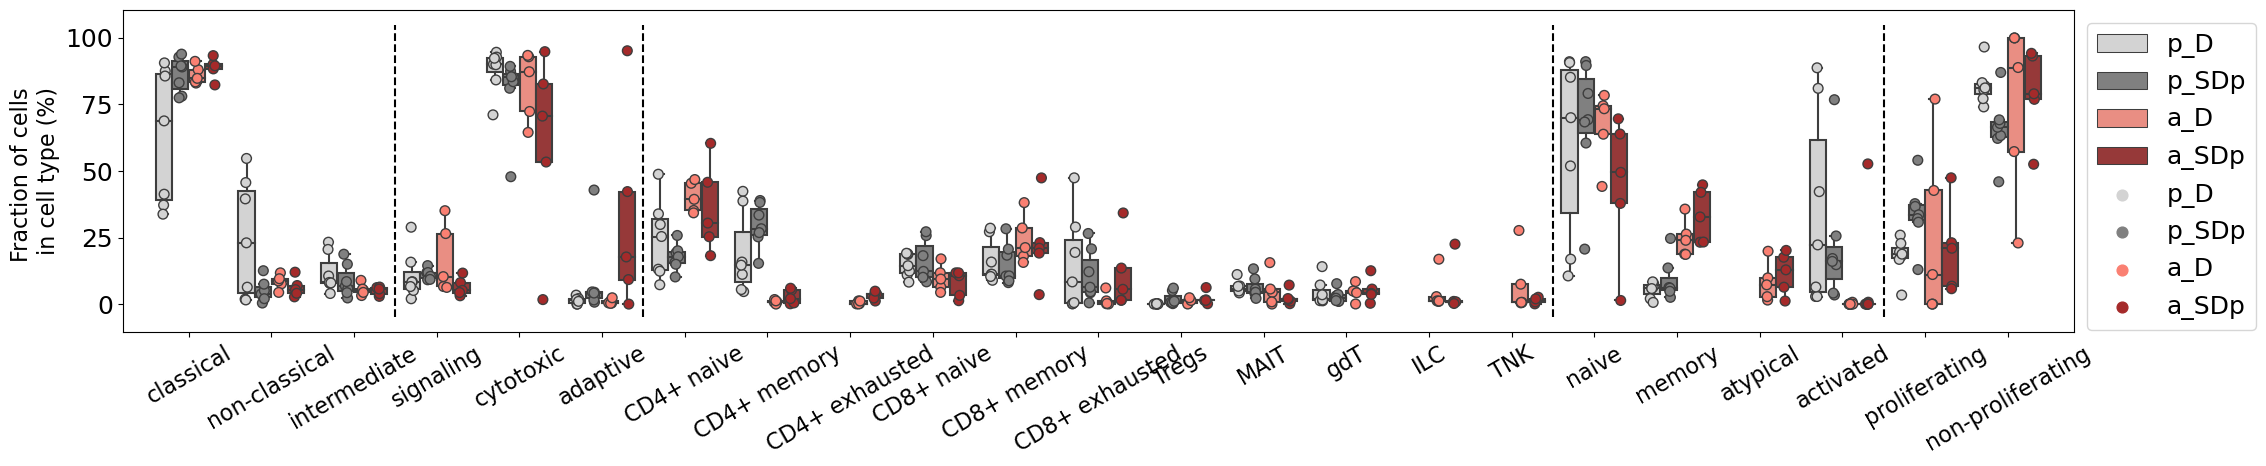

In [33]:
## plot cell abundance figure
df['value'] *= 100
cts = ['Monocytes', 'NK cells', 'T cells', 'B cells', 'Plasmablasts']
import matplotlib.pyplot as plt

palette = sns.color_palette("Paired", 6)[:2]+sns.color_palette("Paired", 6)[4:]
palette = ['lightgray', 'gray', 'salmon', 'brown']

i = len(df.cell_subtype_new.unique())
fig, ax = plt.subplots(figsize=[i*1, 5])
sns.boxplot(data = df,
            x = 'cell_subtype_new', y = 'value', #order=['p_D', 'p_SDp', 'a_D', 'a_SDp'],
            hue='Condition', hue_order = ['p_D', 'p_SDp', 'a_D', 'a_SDp'],
            palette=palette, width=0.8, ax=ax, showfliers=False)
sns.stripplot(data = df, 
              x = 'cell_subtype_new', y = 'value', #order=['p_D', 'p_SDp', 'a_D', 'a_SDp'], #order='Condition',
              hue = 'Condition', hue_order = ['p_D', 'p_SDp', 'a_D', 'a_SDp'],
              #hue='Dengue_exposure', hue_order = ['Primary', 'Secondary', 'ndet', 'no'], 
              #palette = ['tomato', 'steelblue', 'gray', 'gray'],
             palette=palette,  
              s=7, ax=ax, linewidth=1, dodge=True)


ax.legend(bbox_to_anchor=(1, 1))
ax.set_ylabel('Fraction of cells \nin cell type (%)', size=16)
ax.set_xlabel(None)
ylim = ax.get_ylim()
ax.vlines([2.5,5.5,16.5, 20.5], ylim[0], ylim[1], color='black', linestyles='dashed')
#ax.set_yscale('log')
labels = [x.get_text() for x in ax.get_xticklabels()]
labels_n = []
for x in labels:
    if 'T cells' not in x: labels_n.append(x.split()[0])
    else: labels_n.append(x.split(' T cells')[0])
ax.set_xticklabels(labels_n, rotation=30, size=16)
fig.tight_layout()
#plt.savefig(f'{save_figures}cell_subtype_abundance.jpg')
plt.show()



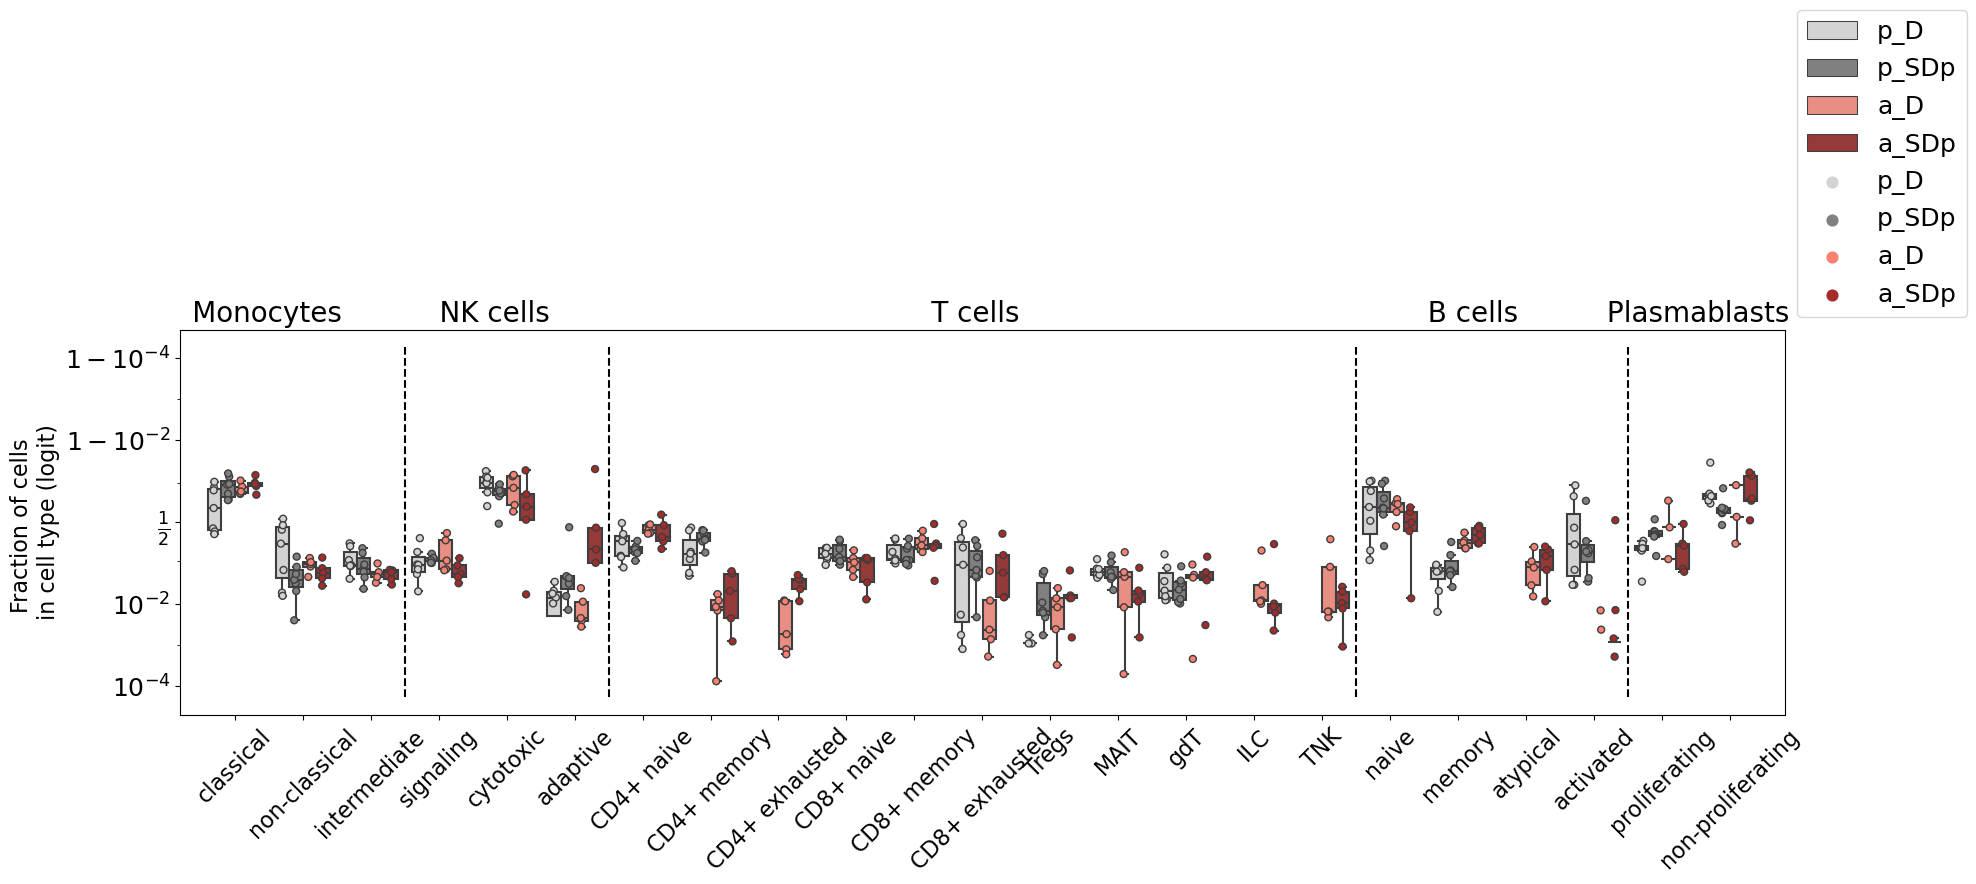

In [43]:
## plot cell abundance figure
df['value'] /= 100
cts = ['Monocytes', 'NK cells', 'T cells', 'B cells', 'Plasmablasts']
import matplotlib.pyplot as plt

palette = sns.color_palette("Paired", 6)[:2]+sns.color_palette("Paired", 6)[4:]
palette = ['lightgray', 'gray', 'salmon', 'brown']

i = len(df.cell_subtype_new.unique())
fig, ax = plt.subplots(figsize=[i*0.9, 5])
sns.boxplot(data = df,
            x = 'cell_subtype_new', y = 'value', #order=['p_D', 'p_SDp', 'a_D', 'a_SDp'],
            hue='Condition', hue_order = ['p_D', 'p_SDp', 'a_D', 'a_SDp'],
            palette=palette, width=0.8, ax=ax, showfliers=False)
sns.stripplot(data = df, 
              x = 'cell_subtype_new', y = 'value', #order=['p_D', 'p_SDp', 'a_D', 'a_SDp'], #order='Condition',
              hue = 'Condition', hue_order = ['p_D', 'p_SDp', 'a_D', 'a_SDp'],
              #hue='Dengue_exposure', hue_order = ['Primary', 'Secondary', 'ndet', 'no'], 
              #palette = ['tomato', 'steelblue', 'gray', 'gray'],
             palette=palette,  
              s=5, ax=ax, linewidth=1, dodge=True)


ax.legend(bbox_to_anchor=(1, 1))
ax.set_ylabel('Fraction of cells \nin cell type (logit)', size=16)
ax.set_xlabel(None)
ax.set_yscale('logit')
ylim = ax.get_ylim()
ax.vlines([2.5,5.5,16.5, 20.5], ylim[0], ylim[1], color='black', linestyles='dashed')
#ax.set_yscale('log')
labels = [x.get_text() for x in ax.get_xticklabels()]
labels_n = []
for x in labels:
    if 'T cells' not in x: labels_n.append(x.split()[0])
    else: labels_n.append(x.split(' T cells')[0])
ax.set_xticklabels(labels_n, rotation=45, size=16, position=(-1,0)) 
ax.set_title('      Monocytes           NK cells                                           T cells                                              B cells          Plasmablasts    ', size=20)
fig.tight_layout()
#plt.savefig(f'{save_figures}cell_subtype_abundance_logit.svg')
plt.show()


In [44]:
df

cell_subtype_new        ID Condition     value  \
0               classical monocytes  1-056-01       a_D  0.830467   
1               classical monocytes  1-172-01       a_D  0.834646   
2               classical monocytes   1_001_1     a_SDp  0.901163   
3               classical monocytes   1_003_1       a_D  0.880802   
4               classical monocytes  1_013_01     a_SDp  0.883721   
..                              ...       ...       ...       ...   
501  non-proliferating plasmablasts  5_130_01       p_D  0.832000   
502  non-proliferating plasmablasts  5_154_01       p_D  0.772059   
503  non-proliferating plasmablasts  5_193_01     p_SDp  0.692308   
504  non-proliferating plasmablasts  6_001_01       p_D  0.812283   
505  non-proliferating plasmablasts  6_023_01       p_D  0.965960   

    Dengue_exposure  
0         Secondary  
1         Secondary  
2         Secondary  
3         Secondary  
4         Secondary  
..              ...  
501       Secondary  
502            ndet  
503       Secondary  
504         Primary  
505       Secondary  

[506 rows x 5 columns]

In [45]:
new_df = df.groupby(['cell_subtype_new', 'Condition']).mean().reset_index()
new_df = new_df.pivot(index='cell_subtype_new', columns='Condition', values= 'value').fillna(0)
new_df['Adults effect size (log2 fold change)'] = np.log2((new_df['a_SDp']+0.0001)/ (new_df['a_D']+0.0001))
new_df['Children effect size (log2 fold change)'] = np.log2((new_df['p_SDp']+0.0001)/ (new_df['p_D']+0.0001))
new_df

Condition                            a_D     a_SDp       p_D     p_SDp  \
cell_subtype_new                                                         
CD4+ exhausted T cells          0.005361  0.031876  0.000000  0.000000   
CD4+ memory T cells             0.008960  0.027718  0.189763  0.294772   
CD4+ naive T cells              0.402028  0.360249  0.243884  0.176807   
CD8+ exhausted T cells          0.015397  0.112487  0.149928  0.107404   
CD8+ memory T cells             0.243231  0.228461  0.161800  0.150375   
CD8+ naive T cells              0.097954  0.077451  0.146743  0.160087   
ILC                             0.046084  0.050505  0.000000  0.000000   
MAIT                            0.053031  0.024564  0.063215  0.061829   
TNK cells                       0.073845  0.012890  0.000000  0.000000   
Tregs                           0.009721  0.021423  0.000562  0.020192   
activated B cells               0.000933  0.053579  0.352130  0.225589   
adaptive NK cells               0.009277  0.328767  0.013813  0.087631   
atypical B cells                0.082517  0.116328  0.000000  0.000000   
classical monocytes             0.861226  0.887464  0.635745  0.863002   
cytotoxic NK cells              0.821124  0.606521  0.878917  0.799921   
gdT                             0.044388  0.052374  0.044105  0.028535   
intermediate monocytes          0.054798  0.050156  0.117493  0.087716   
memory B cells                  0.246842  0.332238  0.052925  0.090423   
naive B cells                   0.668776  0.444381  0.594946  0.683988   
non-classical monocytes         0.083976  0.062379  0.246761  0.049281   
non-proliferating plasmablasts  0.738320  0.791847  0.821029  0.660159   
proliferating plasmablasts      0.261680  0.208049  0.178971  0.339841   
signaling NK cells              0.169599  0.064712  0.107270  0.112448   

Condition                       Adults effect size (log2 fold change)  \
cell_subtype_new                                                        
CD4+ exhausted T cells                                       2.549883   
CD4+ memory T cells                                          1.618452   
CD4+ naive T cells                                          -0.158259   
CD8+ exhausted T cells                                       2.860957   
CD8+ memory T cells                                         -0.090339   
CD8+ naive T cells                                          -0.338433   
ILC                                                          0.131898   
MAIT                                                        -1.107147   
TNK cells                                                   -2.509023   
Tregs                                                        1.131968   
activated B cells                                            5.699738   
adaptive NK cells                                            5.132252   
atypical B cells                                             0.494929   
classical monocytes                                          0.043292   
cytotoxic NK cells                                          -0.436980   
gdT                                                          0.238175   
intermediate monocytes                                      -0.127448   
memory B cells                                               0.428482   
naive B cells                                               -0.589618   
non-classical monocytes                                     -0.428313   
non-proliferating plasmablasts                               0.100961   
proliferating plasmablasts                                  -0.330734   
signaling NK cells                                          -1.388657   

Condition                       Children effect size (log2 fold change)  
cell_subtype_new                                                         
CD4+ exhausted T cells                                         0.000000  
CD4+ memory T cells                                            0.635132  
CD4+ naive T cells         

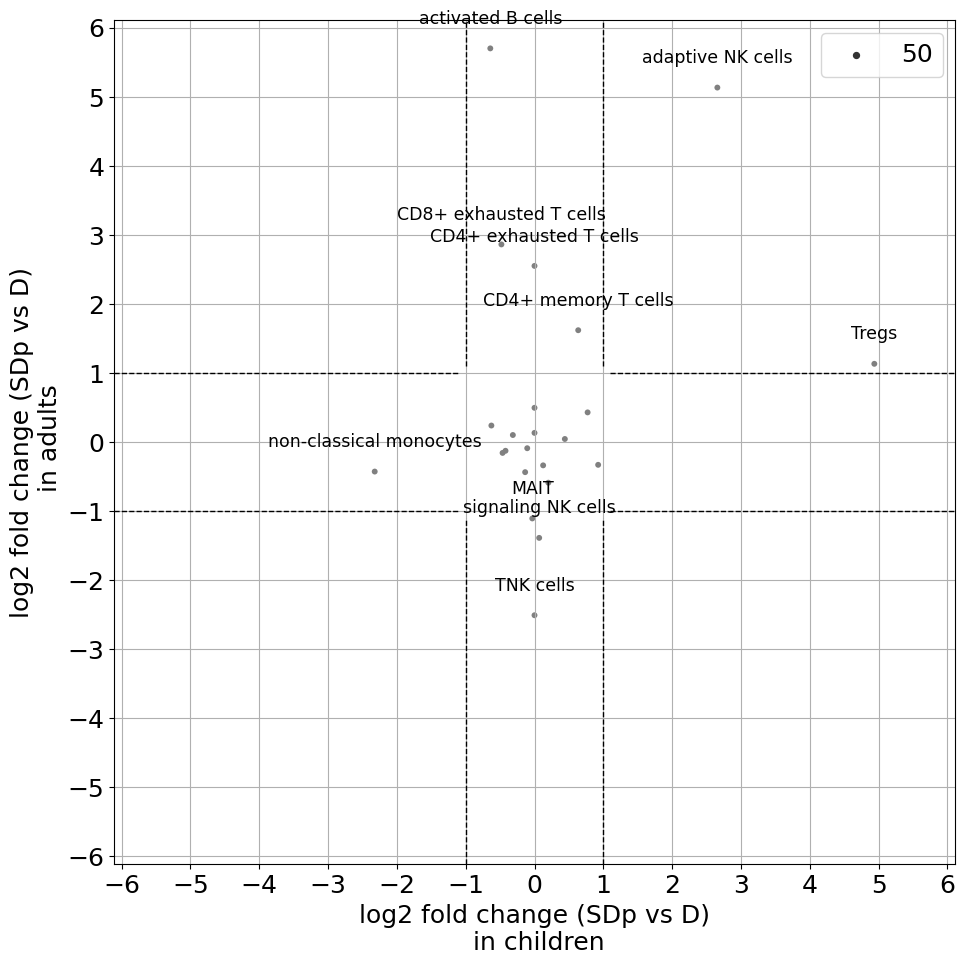

In [47]:
fig, ax = plt.subplots(figsize=(10,10))
cy_col='Adults effect size (log2 fold change)'
sc_col='Children effect size (log2 fold change)'
sns.scatterplot(data=new_df, x=sc_col, y=cy_col, ax=ax, 
                #hue='genes', hue_order=hue_order,
                #style = 'cell_type', 
                    #markers= markers, 
                size = 50, color='gray',
                #palette=sns.color_palette("tab10"), 
                edgecolor='none', s=3)
        
h, l = ax.get_legend_handles_labels()
ax.legend(h[-5:], l[-5:], bbox_to_anchor=(1., 1)).set_title('Cell Types')

genes = list(set([*new_df[abs(new_df[sc_col])>1].index.to_list(), *new_df[abs(new_df[cy_col])>1].index.to_list()]))
for gene in genes:
    ax.text(new_df[sc_col][gene]+0., new_df[cy_col][gene]+0.3, gene, ha='center', va='bottom', size='x-small')



ax.grid(True)
ax.set_xlabel('log2 fold change (SDp vs D)\n in children')
ax.set_ylabel('log2 fold change (SDp vs D)\n in adults')
    
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
lim = max(abs(xmin), abs(xmax), abs(ymin), abs(ymax))

ax.axhline(y = 1, xmin=0, xmax=(lim-1.1)/(lim*2), linestyle = '--', color='black', linewidth=1)
ax.axhline(y = -1, xmin=0, xmax=(lim-1.1)/(lim*2), linestyle = '--', color='black', linewidth=1)
ax.axhline(y = 1, xmin=(lim+1.1)/(lim*2), linestyle = '--', color='black', linewidth=1)
ax.axhline(y = -1, xmin=(lim+1.1)/(lim*2), linestyle = '--', color='black', linewidth=1)
ax.axvline(x = 1, ymin=0, ymax=(lim-1.1)/(lim*2), linestyle = '--', color='black', linewidth=1)
ax.axvline(x = -1, ymax=(lim-1.1)/(lim*2), linestyle = '--', color='black', linewidth=1)
ax.axvline(x = 1, ymin=(lim+1.1)/(lim*2), linestyle = '--', color='black', linewidth=1)
ax.axvline(x = -1, ymin=(lim+1.1)/(lim*2), linestyle = '--', color='black', linewidth=1)

ax.set_xlim(-1*lim, lim)
ax.set_xticks(range(-1*int(lim),int(lim)+1,1))
ax.set_ylim(-1*lim, lim)
ax.set_yticks(range(-1*int(lim),int(lim)+1,1))
    

    #ax.set_title(ct)
    #ax.get_legend().remove()
ax.legend(bbox_to_anchor=(1, 1))
fig.tight_layout()
#plt.savefig(save_figures + f'adults_vs_children_ct_fractions_scatterplots.svg')
